In [1]:
import sys
import os
from os import listdir
from os.path import isfile, join
sys.path.insert(0, join(os.getcwd(),os.pardir))
import json
import pandas as pd 

from recipe_1m_analysis.ingr_normalization import normalize_ingredient

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
FOLDER_PATH = "F:\\user\\Google Drive\\Catherning Folder\\THU\\Thesis\\Work\\Recipe datasets\\scirep-cuisines-detail"
FILES = ["allr_recipes.txt","epic_recipes.txt","menu_recipes.txt"]
map_file = "map.txt"

In [3]:
recipes = []
for file in FILES:
    with open(os.path.join(FOLDER_PATH,file)) as f:
        for i,recipe in enumerate(f):
            data = recipe.strip('\n').split('\t')
            list_ingr = []
            for ingr_raw in data[1:]:
                try:
                    list_ingr.append(normalize_ingredient(ingr_raw).name)
                except AttributeError:
                    continue
            recipes.append({"cuisine":data[0],"id":i,"ingredients":list(set(list_ingr))})
        
df_train = pd.DataFrame(recipes)
df_train['all_ingredients'] = df_train['ingredients'].map(";".join)

In [4]:
df_train

,cuisine,id,ingredients,all_ingredients
0,Canada,0,"[yeast, milk, wheat, egg, lard]",yeast;milk;wheat;egg;lard
1,Canada,1,"[onion, pea, potato, carrot, pork]",onion;pea;potato;carrot;pork
2,Canada,2,[maple_syrup],maple_syrup
3,Canada,3,"[yeast, almond, vegetable_oil, honey, wheat, o...",yeast;almond;vegetable_oil;honey;wheat;oat;dat...
4,Canada,4,"[onion, thyme, ginger, lovage, yeast, cinnamon...",onion;thyme;ginger;lovage;yeast;cinnamon;clam;...
5,Canada,5,"[ginger, raisin, milk, cane_molass, butter, wh...",ginger;raisin;milk;cane_molass;butter;wheat;eg...
6,Canada,6,"[tomato, pepper, olive_oil, garlic, asparagus]",tomato;pepper;olive_oil;garlic;asparagus
7,Canada,7,"[vegetable, cilantro, brown_rice, butter, jasm...",vegetable;cilantro;brown_rice;butter;jasmine;tea
8,Canada,8,"[wheat, egg, vegetable_oil, milk]",wheat;egg;vegetable_oil;milk
9,Canada,9,"[onion, ginger, white_wine, vegetable_oil, gar...",onion;ginger;white_wine;vegetable_oil;garlic;l...


In [5]:
df_train['cuisine'].value_counts()
40150/57691

0.6959491081797854

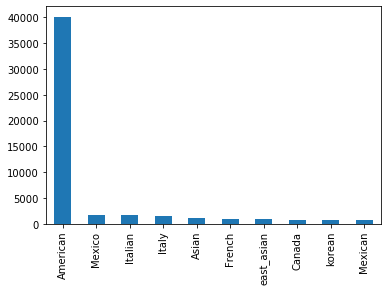

In [6]:
df_train['cuisine'].value_counts()
df_train['cuisine'].value_counts().head(10).plot(kind='bar')

### Data cleaning

In [7]:
replace_dict = {}
with open(os.path.join(FOLDER_PATH,map_file)) as f:
    for line in f:
        l = line.split()
        try:
            replace_dict[l[0]]=l[1]
        except IndexError:
            pass
replace_dict["asian"]="Asian"

In [8]:
df_train=df_train.replace(replace_dict)
df_train['cuisine'].value_counts()

NorthAmerican       41524
SouthernEuropean     4180
LatinAmerican        2917
WesternEuropean      2659
EastAsian            2512
Asian                1193
MiddleEastern         645
SouthAsian            621
SoutheastAsian        457
EasternEuropean       381
African               352
NorthernEuropean      250
Name: cuisine, dtype: int64

## Removing cuisines with not enough recipes

In [9]:
RECIPE_THRESHOLD=10
cuisine_count= df_train['cuisine'].value_counts()
to_drop = [cuisine_count[cuisine_count == el].index[0] for el in cuisine_count if el<RECIPE_THRESHOLD]
df_train = df_train[~df_train["cuisine"].isin(to_drop)]

In [10]:
len(df_train)

57691

In [11]:
# Saving the cleaned data
df_train.to_pickle(os.path.join(FOLDER_PATH,"full_data.pkl"))

In [12]:
df_train

,cuisine,id,ingredients,all_ingredients
0,NorthAmerican,0,"[yeast, milk, wheat, egg, lard]",yeast;milk;wheat;egg;lard
1,NorthAmerican,1,"[onion, pea, potato, carrot, pork]",onion;pea;potato;carrot;pork
2,NorthAmerican,2,[maple_syrup],maple_syrup
3,NorthAmerican,3,"[yeast, almond, vegetable_oil, honey, wheat, o...",yeast;almond;vegetable_oil;honey;wheat;oat;dat...
4,NorthAmerican,4,"[onion, thyme, ginger, lovage, yeast, cinnamon...",onion;thyme;ginger;lovage;yeast;cinnamon;clam;...
5,NorthAmerican,5,"[ginger, raisin, milk, cane_molass, butter, wh...",ginger;raisin;milk;cane_molass;butter;wheat;eg...
6,NorthAmerican,6,"[tomato, pepper, olive_oil, garlic, asparagus]",tomato;pepper;olive_oil;garlic;asparagus
7,NorthAmerican,7,"[vegetable, cilantro, brown_rice, butter, jasm...",vegetable;cilantro;brown_rice;butter;jasmine;tea
8,NorthAmerican,8,"[wheat, egg, vegetable_oil, milk]",wheat;egg;vegetable_oil;milk
9,NorthAmerican,9,"[onion, ginger, white_wine, vegetable_oil, gar...",onion;ginger;white_wine;vegetable_oil;garlic;l...
